# Capstone 3 - Pre-processing and modeling

Can we predict the electricity load for three cities of Panama, considering meteorologic conditions, holidays, and school schedule?

In [1]:
# Modules importation
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
# Importing the dataset
data = pd.read_csv(r'C:\Users\laurence\OneDrive\Data Science\Capstone 3\capstone3_data_EDA.csv')
data.datetime = pd.to_datetime(data.datetime)
data = data.set_index("datetime")

In [3]:
# Droping the 2020 data, affected by the global pandemic.
data = data[(data['year'] != 2020)]

In [4]:
# Resampling on a weekly basis
data_w = data['nat_elec_load'].resample("W").sum()
data_w.drop(data_w.tail(1).index,inplace=True)
data_w.drop(data_w.head(1).index,inplace=True)
data_w = pd.DataFrame(data_w)

In [5]:
# Visualization of end of the dataset to see the last entries
data_w.tail(3)

,nat_elec_load
datetime,
2019-12-15,220102.1454
2019-12-22,225592.3476
2019-12-29,206109.1895


<AxesSubplot:xlabel='datetime'>

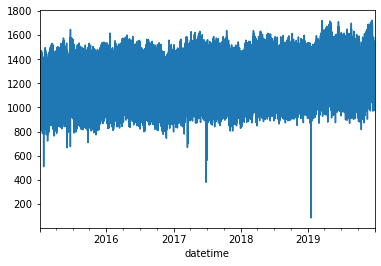

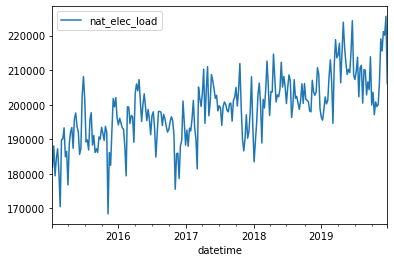

In [6]:
# Visualization of the original and resampled data on a weekly basis.
data['nat_elec_load'].plot()
data_w.plot()

<AxesSubplot:xlabel='datetime'>

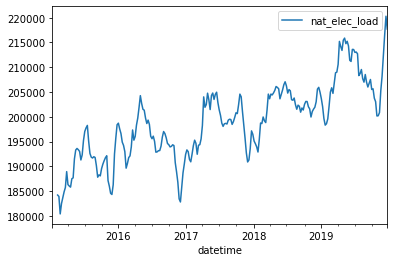

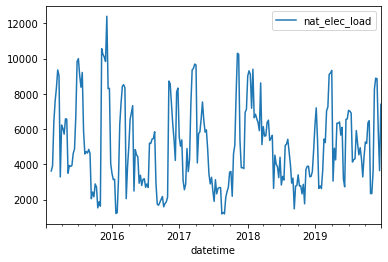

In [7]:
# Verification of the stationarity of the nat_elec_load feature
rolling_mean = data_w.rolling(window = 5).mean()
rolling_std = data_w.rolling(window = 5).std()

rolling_mean.plot()
rolling_std.plot()

The rolling standard deviation is flat, while there is an increase in the rolling mean.

In [8]:
# Augmented Dickey-Fuller test to verify stationarity
adfuller(data_w)

(-2.3280140475257887,
 0.16309197981763768,
 5,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4926.952670738553)

The p value is over 0.05. The null hypothesis is not rejected, indicating that the data is considered as not stationary.

In [9]:
# Transformation of the data into stationary
data_w["diff_1"] = data_w["nat_elec_load"].diff()
data_w.head()

,nat_elec_load,diff_1
datetime,,
2015-01-11,181919.6224,NaN
2015-01-18,188082.3152,6162.6928
2015-01-25,179448.7184,-8633.5968
2015-02-01,184393.4256,4944.7072
2015-02-08,187290.1846,2896.7590


In [10]:
# Verification of the Dickey-Fuller test on the diff_1
adfuller(data_w["diff_1"].dropna())

(-12.182456448733662,
 1.3418641029022053e-22,
 4,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4909.081673892859)

The p value is now below 0.05. The null hypothesis is then rejected, indicating that the data is now considered as stationary.

<AxesSubplot:xlabel='datetime'>

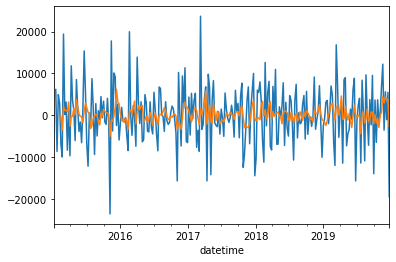

In [11]:
# Visualisation of the diff_1 series to see if it is stationary.
data_w["diff_1"].plot()
data_w['diff_1'].rolling(window = 5).mean().plot()

In [12]:
# Preparation of the new data frame
data_w_diff1 = data_w["diff_1"].dropna()
data_w_diff1 = pd.DataFrame(data_w_diff1)

In [13]:
# Train test split - test dataset corresponding to the 2019 year.
train = data_w_diff1[:207] 
test = data_w_diff1[207:]

## Univariate ARIMA model

In [14]:
# Parameter tuning using stepwise_model
stepwise_model = auto_arima(data_w_diff1, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0,
                            seasonal = True, d = 1, D = 1, traca = True, error_action = 'ignore', suppress_warnings = True,
                            stepwise = True)

In [15]:
# Printing the Akaike information criterion 
print(stepwise_model.aic())

5122.068943672036


In [16]:
# Training data using the tuned model
stepwise_model.fit(train)

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [17]:
# Making prediction for 2019
future_forecast = stepwise_model.predict(n_periods = 53)
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns = ['Prediction'])

<AxesSubplot:xlabel='datetime'>

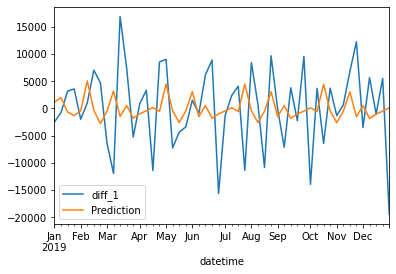

In [18]:
# Visualisation of the transformed real and predicted data
pd.concat([test, future_forecast], axis = 1).plot()

<AxesSubplot:xlabel='datetime'>

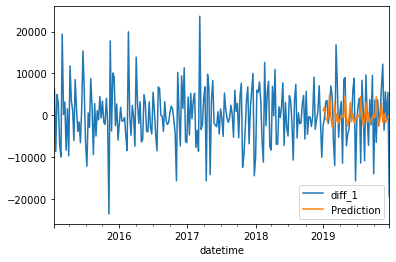

In [19]:
# Visualisation of the transformed real and predicted data in context
pd.concat([data_w_diff1, future_forecast], axis = 1).plot()

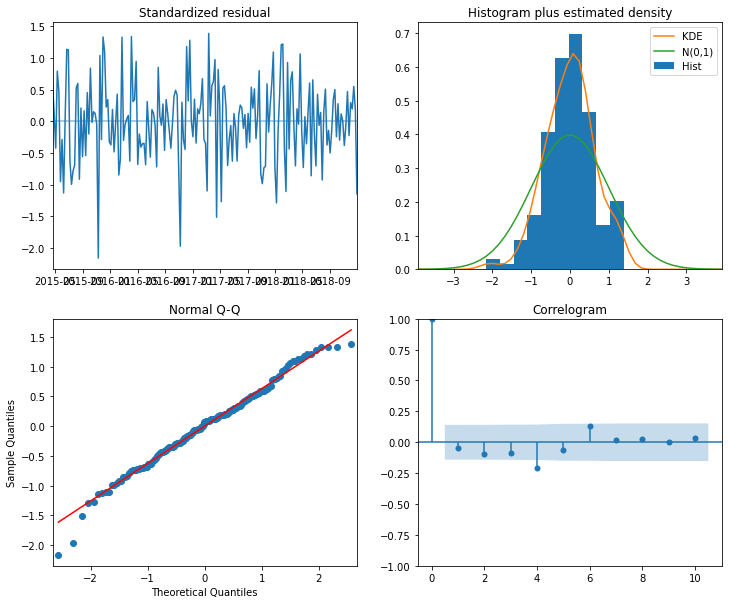

In [20]:
# Visualisation of the model diagnostic
stepwise_model.plot_diagnostics(figsize=(12,10))
plt.show()

In [21]:
# Printing the model summary
print(stepwise_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  207
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2016.174
Date:                            Sat, 11 Feb 2023   AIC                           4044.348
Time:                                    21:14:26   BIC                           4063.955
Sample:                                01-18-2015   HQIC                          4052.287
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3249      0.167     -1.940      0.052      -0.653       0.003
ar.L2         -0.3632      0.187   

In [22]:
# Printing the root mean square error of the model result
error = np.sqrt(mean_squared_error(test, future_forecast))
error

7950.109614738195

<AxesSubplot:xlabel='datetime'>

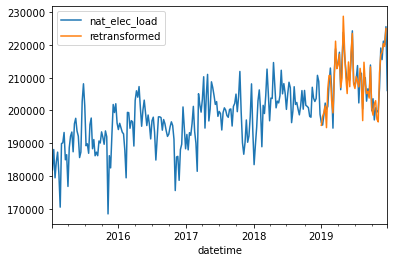

In [27]:
# Restoration of the modelized data
data_w['retransformed'] = data_w['nat_elec_load'] + (future_forecast['Prediction']).diff(-1)
data_w[['nat_elec_load', 'retransformed']].plot()

<AxesSubplot:xlabel='datetime'>

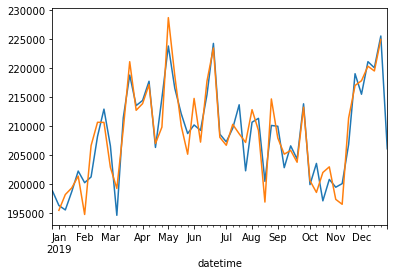

In [28]:
# Comparison of the real and modelized data    
d2019_vrai = data_w['nat_elec_load'][207:]
d2019_model = data_w['retransformed'][207:]
d2019_vrai.plot()
d2019_model.plot()

## Multivariate Arima model

In [29]:
# Resampling on a weekly basis with the sum or the mean, depending on the feature
data_multi = pd.DataFrame()
data_multi['nat_elec_load'] = data['nat_elec_load'].resample("W").sum()
data_multi['t_toc'] = data['t_toc'].resample("W").mean()
data_multi['h_toc'] = data['h_toc'].resample("W").mean()
data_multi['p_toc'] = data['p_toc'].resample("W").sum()
data_multi['ws_toc'] = data['ws_toc'].resample("W").mean()
data_multi['t_san'] = data['t_san'].resample("W").mean()
data_multi['h_san'] = data['h_san'].resample("W").mean()
data_multi['p_san'] = data['p_san'].resample("W").sum()
data_multi['ws_san'] = data['ws_san'].resample("W").mean()
data_multi['t_dav'] = data['t_dav'].resample("W").mean()
data_multi['h_dav'] = data['h_dav'].resample("W").mean()
data_multi['p_dav'] = data['p_dav'].resample("W").sum()
data_multi['ws_dav'] = data['ws_dav'].resample("W").mean()
data_multi['holiday_ID'] = data['holiday_ID'].resample("W").sum()
data_multi['holiday'] = data['holiday'].resample("W").sum()
data_multi['school'] = data['school'].resample("W").sum()

data_multi.drop(data_multi.tail(1).index,inplace=True)
data_multi.drop(data_multi.head(1).index,inplace=True)
data_multi = pd.DataFrame(data_multi)

data_multi.head()

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-11,181919.6224,26.829882,0.017483,3.443329,25.429599,25.733156,0.016941,3.995602,13.844652,23.820581,0.015845,17.169937,6.687586,48.0,24.0,0.0
2015-01-18,188082.3152,27.047046,0.017778,7.872233,20.616549,26.108616,0.017291,11.167252,8.728468,24.394144,0.016080,20.262146,3.462595,0.0,0.0,0.0
2015-01-25,179448.7184,26.586434,0.016808,13.071503,18.210324,25.853082,0.016226,13.993546,8.015694,23.845967,0.015266,19.622757,3.004145,0.0,0.0,0.0
2015-02-01,184393.4256,27.024779,0.016309,5.475823,24.159216,26.246552,0.015350,6.404824,12.579642,23.686981,0.014966,15.239387,5.659424,0.0,0.0,0.0
2015-02-08,187290.1846,27.346896,0.017026,5.995931,20.208824,27.558020,0.016060,10.450697,9.342399,24.438553,0.015646,18.350250,3.755133,0.0,0.0,0.0


In [31]:
# Definition of a function to obtain the Dickey-Fuller test results for all features of the dataset.
def adfuller_test(series, signif=0.05):
    x = adfuller(series, autolag='AIC')
    output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }
    for key, val in x[4].items():
         output[f'Critical value {key}'] = val
    return pd.Series(output)

In [32]:
data_multi.apply(lambda x: adfuller_test(x), axis=0)

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
Test Statistic,-2.328014,-4.147768,-4.920268,-3.77971,-4.615757,-4.209354,-5.190418,-4.848723,-4.397102,-4.349681,-5.064249,-4.004139,-5.41961,-3.754414,-4.207352,-3.958252
P-value,0.163092,0.000807,0.000032,0.003122,0.000121,0.000635,0.000009,0.000044,0.0003,0.000364,0.000017,0.001389,0.000003,0.00341,0.00064,0.001646
Number of lags,5,2,9,2,8,0,7,8,2,0,7,2,2,6,6,16
Number of observations,254,257,250,257,251,259,252,251,257,259,252,257,257,253,253,243
Reject (signif. level 0.05),False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Critical value 1%,-3.45636,-3.456054,-3.456781,-3.456054,-3.456674,-3.455853,-3.456569,-3.456674,-3.456054,-3.455853,-3.456569,-3.456054,-3.456054,-3.456464,-3.456464,-3.457551
Critical value 5%,-2.872987,-2.872853,-2.873172,-2.872853,-2.873125,-2.872765,-2.873079,-2.873125,-2.872853,-2.872765,-2.873079,-2.872853,-2.872853,-2.873033,-2.873033,-2.873509
Critical value 10%,-2.57287,-2.572799,-2.572969,-2.572799,-2.572944,-2.572752,-2.572919,-2.572944,-2.572799,-2.572752,-2.572919,-2.572799,-2.572799,-2.572895,-2.572895,-2.573148


As seen before, nat_elec_load is not stationary, but it is the only one non-stationary feature of the dataset. We already know that one degree differenciation is enough to transform the data into stationary.

In [33]:
# Transformation of the data into stationary
data_multi["nat_elec_load_diff_1"] = data_multi["nat_elec_load"].diff()
data_multi_diff1 = data_multi.drop('nat_elec_load', axis=1)

In [36]:
# Train test split - test dataset corresponding to the 2019 year.
train = data_multi_diff1[1:207] 
test = data_multi_diff1[207:]

In [45]:
model = auto_arima(data_multi['nat_elec_load'], m=12, seasonal=True, start_p=0, start_q=0, max_order=4, test='adf',
                   error_action='ignore',suppress_warnings=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5466.359, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5497.587, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5300.880, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5378.076, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7084.837, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5303.654, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5302.817, Time=1.78 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5302.696, Time=0.86 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5301.057, Time=0.27 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=5304.391, Time=1.41 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=5499.501, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5300.925, Time=0.76 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=5300.183, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5301.032, Time=0.10 sec
 ARIMA(1,0,1)(2,0,0

In [46]:
# Printing the Akaike information criterion 
print(model.aic())

5284.618674784197


In [49]:
# Training data using the model
model.fit(train["nat_elec_load_diff_1"])

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [51]:
# Making prediction for 2019
future_forecast2 = model.predict(n_periods=53)
future_forecast2 = pd.DataFrame(future_forecast2, index = test.index, columns = ['Prediction'])

<AxesSubplot:xlabel='datetime'>

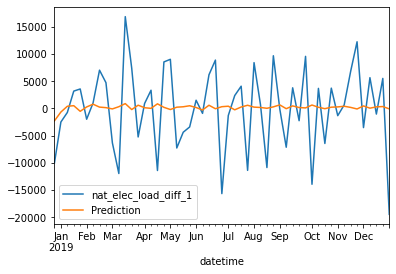

In [53]:
# Visualisation of the transformed real and predicted data
pd.concat([test["nat_elec_load_diff_1"], future_forecast2], axis = 1).plot()

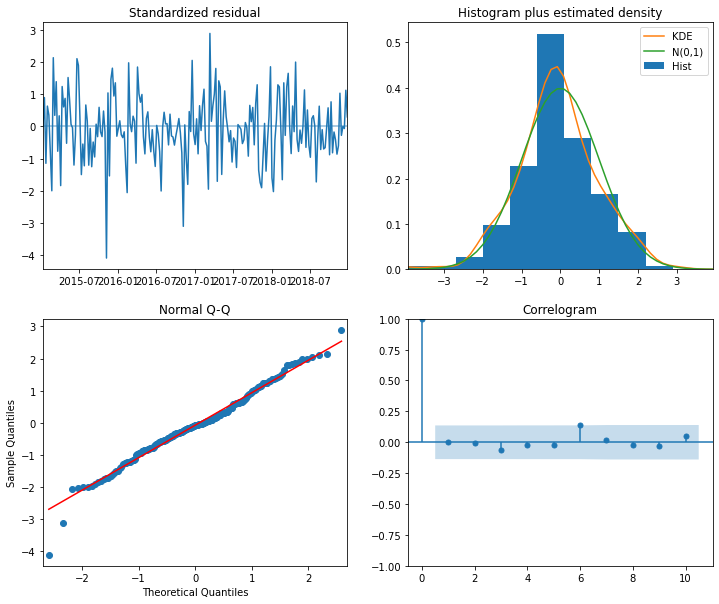

In [56]:
# Visualisation of the model diagnostic
model.plot_diagnostics(figsize=(12,10))
plt.show()

In [57]:
# Printing the model summary
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  207
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -2079.300
Date:                              Sat, 11 Feb 2023   AIC                           4172.600
Time:                                      22:20:30   BIC                           4195.929
Sample:                                  01-11-2015   HQIC                          4182.034
                                       - 12-23-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    402.4504    250.288      1.608      0.108     -88.105     893.006
ar.L1         -0.06

In [59]:
# Printing the root mean square error of the model result
error = np.sqrt(mean_squared_error(test['nat_elec_load_diff_1'], future_forecast2))
error

7527.156432401574

<AxesSubplot:xlabel='datetime'>

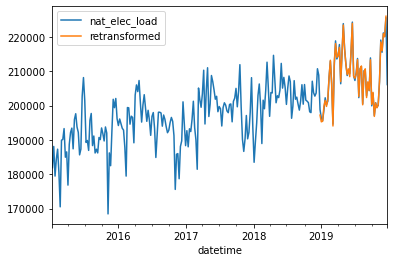

In [60]:
# Restoration of the modelized data
data_multi['retransformed'] = data_multi['nat_elec_load'] + (future_forecast2['Prediction']).diff(-1)
data_multi[['nat_elec_load', 'retransformed']].plot()

<AxesSubplot:xlabel='datetime'>

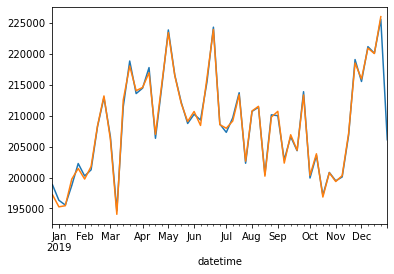

In [61]:
# Comparison of the real and modelized data    
d2019_vrai = data_multi['nat_elec_load'][207:]
d2019_model = data_multi['retransformed'][207:]
d2019_vrai.plot()
d2019_model.plot()